# **I. Setup libraries and environments**

In [ ]:
# Install required packages
!pip install pyspark==3.3.2
!pip install xgboost
!pip install gradio
!pip install openpyxl
!pip install scikit-learn
!pip install pandas ==1.5.3
!pip install findspark
!pip install numpy
!export PYSPARK_SUBMIT_ARGS="--driver-memory 8g pyspark-shell"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 15.8 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824006 sha256=de3a6608e2759063ff3b1ceea0d1d9605d132145829ec0fb3f94270411575c7c
  Stored in directory: /root/.cache/pip/wheels/47/69/84/c7c7776e2287a654536f5cba7dc54c904c03aa2c3e29206f0f
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.4
    Uninstalling pyspark-3.5.4:
      Successfully uninstalled pyspark-3.5.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-spark-conne

In [ ]:
import os
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import pickle
import gradio as gr
import pyspark
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
# Check pandas version
print(pd.__version__)

2.2.2


In [ ]:
# Check PySpark version
print(pyspark.__version__)

3.3.2


In [ ]:
# Set up Google Drive environment
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Update and install Java
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Download and Install Apache Spark
!wget -q https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
!tar xf spark-3.4.1-bin-hadoop3.tgz

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [ ]:
# Set up variable environments for Java and Spark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

# Initialize Spark
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date
from pyspark.ml.feature import StringIndexer

spark = SparkSession.builder \
    .appName("TripTypeClassification") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()

Spark version: 3.4.1


# **II.Read Data**

# Understand dataset metrics:

* ‘TripType’ categorizes shopping behavior.
* ‘VisitNumber’ identifies trips by customers.
* ‘Weekday’ notes shopping day.
* ‘Upc’ is a product identifier.
* ‘ScanCount’ records item purchases/returns.
* ‘DepartmentDescription’ categorizes items.
* ‘FinelineNumber’ refines categories.



In [ ]:
# Read train dataset
url = '/content/drive/MyDrive/DATA/train.csv'
walmart_train = spark.read.csv(url, header=True, inferSchema=True)

In [ ]:
# Displays the structure of the DataFrame train
walmart_train.printSchema()

root
 |-- TripType: integer (nullable = true)
 |-- VisitNumber: integer (nullable = true)
 |-- Weekday: string (nullable = true)
 |-- Upc: long (nullable = true)
 |-- ScanCount: integer (nullable = true)
 |-- DepartmentDescription: string (nullable = true)
 |-- FinelineNumber: integer (nullable = true)



In [ ]:
# Print the first 5 rows
walmart_train.show(5)

# Print the shape of the DataFrame train
num_rows = walmart_train.count()
num_columns = len(walmart_train.columns)
print(f"Shape of the DataFrame: ({num_rows}, {num_columns})")

+--------+-----------+-------+-----------+---------+---------------------+--------------+
|TripType|VisitNumber|Weekday|        Upc|ScanCount|DepartmentDescription|FinelineNumber|
+--------+-----------+-------+-----------+---------+---------------------+--------------+
|     999|          5| Friday|68113152929|       -1|   FINANCIAL SERVICES|          1000|
|      30|          7| Friday|60538815980|        1|                SHOES|          8931|
|      30|          7| Friday| 7410811099|        1|        PERSONAL CARE|          4504|
|      26|          8| Friday| 2238403510|        2| PAINT AND ACCESSO...|          3565|
|      26|          8| Friday| 2006613744|        2| PAINT AND ACCESSO...|          1017|
+--------+-----------+-------+-----------+---------+---------------------+--------------+
only showing top 5 rows

Shape of the DataFrame: (647054, 7)


In [ ]:
# Read test data
url_2 = '/content/drive/MyDrive/DATA/test.csv'
walmart_test = spark.read.csv(url_2, header=True, inferSchema=True)

In [ ]:
# Displays the structure of the test DataFrame
walmart_test.printSchema()

root
 |-- VisitNumber: integer (nullable = true)
 |-- Weekday: string (nullable = true)
 |-- Upc: long (nullable = true)
 |-- ScanCount: integer (nullable = true)
 |-- DepartmentDescription: string (nullable = true)
 |-- FinelineNumber: integer (nullable = true)



In [ ]:
# Print the first 5 rows
walmart_test.show(5)

# Print the shape of the DataFrame test
num_rows = walmart_test.count()
num_columns = len(walmart_test.columns)
print(f"Shape of the DataFrame: ({num_rows}, {num_columns})")

+-----------+-------+-----------+---------+---------------------+--------------+
|VisitNumber|Weekday|        Upc|ScanCount|DepartmentDescription|FinelineNumber|
+-----------+-------+-----------+---------+---------------------+--------------+
|          1| Friday|72503389714|        1|                SHOES|          3002|
|          1| Friday| 1707710732|        1|                DAIRY|          1526|
|          1| Friday|89470001026|        1|                DAIRY|          1431|
|          1| Friday|88491211470|        1|    GROCERY DRY GOODS|          3555|
|          2| Friday| 2840015224|        1|          DSD GROCERY|          4408|
+-----------+-------+-----------+---------+---------------------+--------------+
only showing top 5 rows

Shape of the DataFrame: (653646, 6)


In [ ]:
# Create get shape function
def get_shape(df):
    """
    Returns the shape of a Spark DataFrame as a tuple (num_rows, num_columns).

    Parameters:
    df (pyspark.sql.DataFrame): The Spark DataFrame.

    Returns:
    tuple: (number of rows, number of columns)
    """
    num_rows = df.count()
    num_columns = len(df.columns)
    return (num_rows, num_columns)

# **III. Performing data cleaning, EDA, and generating new features**

## **1. Removing noise**

In [ ]:
from pyspark.sql import Window
from pyspark.sql.functions import row_number

# Create function to count duplicates
def count_duplicates(df):
    """
    Counts the number of duplicate rows in a Spark DataFrame.

    Parameters:
    df (pyspark.sql.DataFrame): The Spark DataFrame.

    Returns:
    int: Number of duplicate rows.
    """
    # Define a window partitioned by all columns
    window = Window.partitionBy(df.columns).orderBy(df.columns)

    # Add a row number column to identify duplicates
    df_with_row_num = df.withColumn("row_num", row_number().over(window))

    # Filter rows where row_num > 1 (these are duplicates)
    duplicates = df_with_row_num.filter(df_with_row_num.row_num > 1)

    # Count the number of duplicate rows
    return duplicates.count()

In [ ]:
# Print original shape of dataframes
print("Original shape of the training dataset: ", get_shape(walmart_train))
print("Original shape of the test dataset: ",  get_shape(walmart_test))

# Count total duplicates of dataframes
print("Total duplicates in the training dataset: ", count_duplicates(walmart_train))
print("Total duplicates in the test dataset: ", count_duplicates(walmart_test))

# Drop duplicates from the training dataset
walmart_train = walmart_train.dropDuplicates()

# Drop duplicates from the test dataset
walmart_test = walmart_test.dropDuplicates()

# Optional: Cache the deduplicated DataFrames for better performance
walmart_train.cache()
walmart_test.cache()

# Print the shape of the deduplicated DataFrames
print("Shape of walmart_train after dropping duplicates: ", get_shape(walmart_train))
print("Shape of walmart_test after dropping duplicates: ", get_shape(walmart_test))

Original shape of the training dataset:  (647054, 7)
Original shape of the test dataset:  (653646, 6)
Total duplicates in the training dataset:  5704
Total duplicates in the test dataset:  5644
Shape of walmart_train after dropping duplicates:  (641350, 7)
Shape of walmart_test after dropping duplicates:  (648002, 6)


**The TripType_999 category serves as a catch-all for trips that don't fall into any defined type, labeled as "other." This can introduce ambiguity and noise, potentially harming the model's performance.**

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

def remove_999_triptype(df):
    # Count unique VisitNumber per TripType and get the top 10
    triptypes_train = (
        df.groupBy("TripType")
        .agg(F.countDistinct("VisitNumber").alias("unique_visits"))
        .orderBy(F.desc("unique_visits"))
        .limit(10)
    )

    triptypes_train.show()

    # Remove rows with TripType 999
    df = df.filter(df.TripType != 999)

    print("Shape of the training dataset after dropping TripType 999: ", (df.count(), len(df.columns)))

    return df

walmart_train = remove_999_triptype(walmart_train)

+--------+-------------+
|TripType|unique_visits|
+--------+-------------+
|       8|        12161|
|      39|         9896|
|       9|         9464|
|     999|         8444|
|      40|         6130|
|       7|         5752|
|       5|         4593|
|      25|         3698|
|       3|         3643|
|      36|         3005|
+--------+-------------+

Shape of the training dataset after dropping TripType 999:  (624136, 7)


## **2. Handling Missing Values**

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

def impute_missing_values(df_train, df_test):
    # Impute 'DepartmentDescription' with mode
    # Calculate the mode of 'DepartmentDescription' separately
    mode_dept_train = df_train.groupby("DepartmentDescription").count().orderBy(F.desc("count")).first()["DepartmentDescription"]
    mode_dept_test = df_test.groupby("DepartmentDescription").count().orderBy(F.desc("count")).first()["DepartmentDescription"]

    # Now use the calculated mode for imputation
    df_train = df_train.fillna({"DepartmentDescription": mode_dept_train})
    df_test = df_test.fillna({"DepartmentDescription": mode_dept_test})

    # Impute 'Upc' with mode
    # Calculate the mode of 'Upc' separately
    mode_upc_train = df_train.groupby("Upc").count().orderBy(F.desc("count")).first()["Upc"]
    mode_upc_test = df_test.groupby("Upc").count().orderBy(F.desc("count")).first()["Upc"]

    # Now use the calculated mode for imputation
    df_train = df_train.fillna({"Upc": mode_upc_train})
    df_test = df_test.fillna({"Upc": mode_upc_test})

    # Impute missing 'FinelineNumber' values
    # 1. Calculate the global mode of 'FinelineNumber' for both train and test datasets
    global_mode_fineline_train = df_train.groupby("FinelineNumber").count().orderBy(F.desc("count")).first()["FinelineNumber"]
    global_mode_fineline_test = df_test.groupby("FinelineNumber").count().orderBy(F.desc("count")).first()["FinelineNumber"]

    # 2. Impute using department-specific mode, falling back to global mode if necessary
    window_spec = Window.partitionBy("DepartmentDescription")
    df_train = df_train.withColumn(
        "FinelineNumber",
        F.coalesce(
            F.col("FinelineNumber"),  # Existing value if not null
            F.first("FinelineNumber", ignorenulls=True).over(window_spec),  # Department mode
            F.lit(global_mode_fineline_train)  # Global mode if department mode is null
        )
    )
    df_test = df_test.withColumn(
        "FinelineNumber",
        F.coalesce(
            F.col("FinelineNumber"),
            F.first("FinelineNumber", ignorenulls=True).over(window_spec),
            F.lit(global_mode_fineline_test)
        )
    )

    return df_train, df_test

walmart_train, walmart_test = impute_missing_values(walmart_train, walmart_test)
print("Our training dataset contains no null values:")
walmart_train.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in walmart_train.columns]).show()
print("Our test dataset contains no null values:")
walmart_test.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in walmart_test.columns]).show()

Our training dataset contains no null values:
+--------+-----------+-------+---+---------+---------------------+--------------+
|TripType|VisitNumber|Weekday|Upc|ScanCount|DepartmentDescription|FinelineNumber|
+--------+-----------+-------+---+---------+---------------------+--------------+
|       0|          0|      0|  0|        0|                    0|             0|
+--------+-----------+-------+---+---------+---------------------+--------------+

Our test dataset contains no null values:
+-----------+-------+---+---------+---------------------+--------------+
|VisitNumber|Weekday|Upc|ScanCount|DepartmentDescription|FinelineNumber|
+-----------+-------+---+---------+---------------------+--------------+
|          0|      0|  0|        0|                    0|             0|
+-----------+-------+---+---------+---------------------+--------------+



## **3. Encoding Categorical Columns**

In [ ]:
def encode_features(df_train, df_test):
    # Frequency Encoding for 'DepartmentDescription'
    freq_encoding = df_train.groupBy("DepartmentDescription").agg(F.count("DepartmentDescription").alias("freq"))
    total_count = df_train.count()
    freq_encoding = freq_encoding.withColumn("Department_Encoded", F.col("freq") / total_count).drop("freq")
    df_train = df_train.join(freq_encoding, on="DepartmentDescription", how="left")
    df_test = df_test.join(freq_encoding, on="DepartmentDescription", how="left")

    # Weekday Encoding
    weekday_mapping = {"Monday": 1, "Tuesday": 2, "Wednesday": 3, "Thursday": 4, "Friday": 5, "Saturday": 6, "Sunday": 7}
    mapping_expr = F.create_map([F.lit(x) for x in sum(weekday_mapping.items(), ())])
    df_train = df_train.withColumn("Weekday_Encoded", mapping_expr[F.col("Weekday")])
    df_test = df_test.withColumn("Weekday_Encoded", mapping_expr[F.col("Weekday")])

    return df_train, df_test

In [ ]:
walmart_train, walmart_test = encode_features(walmart_train, walmart_test)

In [ ]:
print("Encoded Walmart Test: \n", walmart_test.show(5))

+---------------------+-----------+--------+------------+---------+--------------+--------------------+---------------+
|DepartmentDescription|VisitNumber| Weekday|         Upc|ScanCount|FinelineNumber|  Department_Encoded|Weekday_Encoded|
+---------------------+-----------+--------+------------+---------+--------------+--------------------+---------------+
|          ACCESSORIES|       8923|Saturday| 61156655002|       -1|           720|0.001981939833626...|              6|
|          ACCESSORIES|      13472|  Sunday|695334420523|        1|          2104|0.001981939833626...|              7|
|          ACCESSORIES|      13590|  Sunday|489448300020|        2|          3131|0.001981939833626...|              7|
|          ACCESSORIES|     103505|  Sunday|489704810939|        1|          3131|0.001981939833626...|              7|
|          ACCESSORIES|     103898|  Sunday| 88743940629|        1|           317|0.001981939833626...|              7|
+---------------------+-----------+-----

In [ ]:
print("Encoded Walmart Training: \n", walmart_train.show(5))

+---------------------+--------+-----------+---------+-----------+---------+--------------+--------------------+---------------+
|DepartmentDescription|TripType|VisitNumber|  Weekday|        Upc|ScanCount|FinelineNumber|  Department_Encoded|Weekday_Encoded|
+---------------------+--------+-----------+---------+-----------+---------+--------------+--------------------+---------------+
|          ACCESSORIES|      39|      18298|   Sunday|88599865721|        1|           466|0.001981939833626...|              7|
|          ACCESSORIES|       9|      35376|Wednesday|84090303442|        1|           151|0.001981939833626...|              3|
|          ACCESSORIES|      40|      36401|Wednesday| 2592547573|        1|           104|0.001981939833626...|              3|
|          ACCESSORIES|      44|      51046| Saturday|80413430876|        1|           121|0.001981939833626...|              6|
|          ACCESSORIES|      25|      84882| Thursday| 2592549436|        1|           104|0.0019

## **4. Feature Engineering:**


##  Features understand:
*  **TotalItems**: Calculates the total number of items purchased during each trip by summing the ScanCount values.
* **ReturnItems**: Counts the number of returned items during each trip by summing the negative ScanCount values.
* **UniqueItems**: Determines the count of unique items purchased during each trip by considering the distinct UPC values.
* **AverageScanCount**: Calculates the average ScanCount per item for each trip by dividing the sum of ScanCount by the total number of items.
* **DepartmentCount**: Counts the number of different departments visited during each trip by counting the distinct DepartmentDescription values.
* **PopularDepartment**: Identifies the most frequently visited department during each trip by determining the mode of DepartmentDescription.
* **DepartmentFrequency**: Calculates the frequency of visits to each department by grouping the data by VisitNumber and DepartmentDescription and counting the occurrences.
* **WeekdayEncoded**: Encodes the Weekday column into numerical values for modeling purposes. For example, assign Monday as 1, Tuesday as 2, and so on.



In [ ]:
from pyspark.sql.functions import sum as _sum, count, col, expr, approx_count_distinct

# Initialize Spark session
spark = SparkSession.builder.appName("WalmartFeatureEncoding").getOrCreate()

def encode_additional_features(df):
    # Define window specification
    window_spec = Window.partitionBy("VisitNumber")

    # Calculate and encode additional features
    df = df.withColumn("TotalItems", _sum("ScanCount").over(window_spec))
    df = df.withColumn("ReturnItems", _sum("ScanCount").over(window_spec))
    df = df.withColumn("UniqueItems", approx_count_distinct("Upc").over(window_spec))
    df = df.withColumn("DepartmentCount", approx_count_distinct("DepartmentDescription").over(window_spec))

    # For PopularDepartment, we need to calculate the mode
    # PySpark doesn't have a direct mode function, so we use a workaround
    department_count = df.groupBy("VisitNumber", "DepartmentDescription").agg(count("*").alias("DeptCount"))
    window_spec_dept = Window.partitionBy("VisitNumber").orderBy(col("DeptCount").desc())
    popular_department = department_count.withColumn("row_num", expr("row_number() over (partition by VisitNumber order by DeptCount desc)"))
    popular_department = popular_department.filter(col("row_num") == 1).drop("row_num", "DeptCount")

    df = df.join(popular_department.withColumnRenamed("DepartmentDescription", "PopularDepartment"), on="VisitNumber", how="left")

    # For DepartmentFrequency
    df = df.withColumn("DepartmentFrequency", count("VisitNumber").over(Window.partitionBy("VisitNumber", "DepartmentDescription")))

    return df

# Assuming walmart_train and walmart_test are already loaded as PySpark DataFrames
walmart_train = encode_additional_features(walmart_train)
print("Encoded Walmart Training: ")
walmart_train.show(5)

walmart_test = encode_additional_features(walmart_test)
print("Encoded Walmart Test: ")
walmart_test.show(5)

Encoded Walmart Training: 
+-----------+---------------------+--------+-------+-----------+---------+--------------+--------------------+---------------+----------+-----------+-----------+---------------+-----------------+-------------------+
|VisitNumber|DepartmentDescription|TripType|Weekday|        Upc|ScanCount|FinelineNumber|  Department_Encoded|Weekday_Encoded|TotalItems|ReturnItems|UniqueItems|DepartmentCount|PopularDepartment|DepartmentFrequency|
+-----------+---------------------+--------+-------+-----------+---------+--------------+--------------------+---------------+----------+-----------+-----------+---------------+-----------------+-------------------+
|          9|  IMPULSE MERCHANDISE|       8| Friday| 1070080727|        1|           115|0.043791737698193986|              5|         3|          3|          3|              2|          PRODUCE|                  1|
|          9|              PRODUCE|       8| Friday|       4011|        1|          5501|  0.0807275978312419

## **5. Exploratory Data Analysis:**



##***Total Visits per day***

Scatter plots, correlation matrices, and bar charts, insights are revealed into shopping behaviors based on trip types.

<ipython-input-27-ec30abfcc4b7>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Weekday', y='TotalVisits', data=total_visits_pd, palette='viridis')


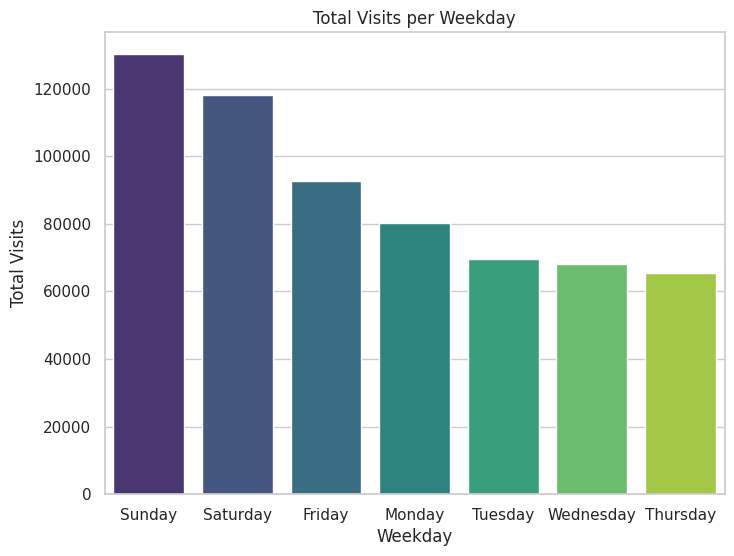

In [ ]:
# Total visits per weekday
total_visits_per_weekday = walmart_train.groupBy("Weekday").agg(count("VisitNumber").alias("TotalVisits"))

total_visits_per_weekday = total_visits_per_weekday.orderBy("TotalVisits", ascending=False)

total_visits_pd = total_visits_per_weekday.toPandas()

# Plot using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(x='Weekday', y='TotalVisits', data=total_visits_pd, palette='viridis')

# Adding labels and title
plt.xlabel('Weekday')
plt.ylabel('Total Visits')
plt.title('Total Visits per Weekday')
plt.show()


##***Popularity of departments by Total Items***

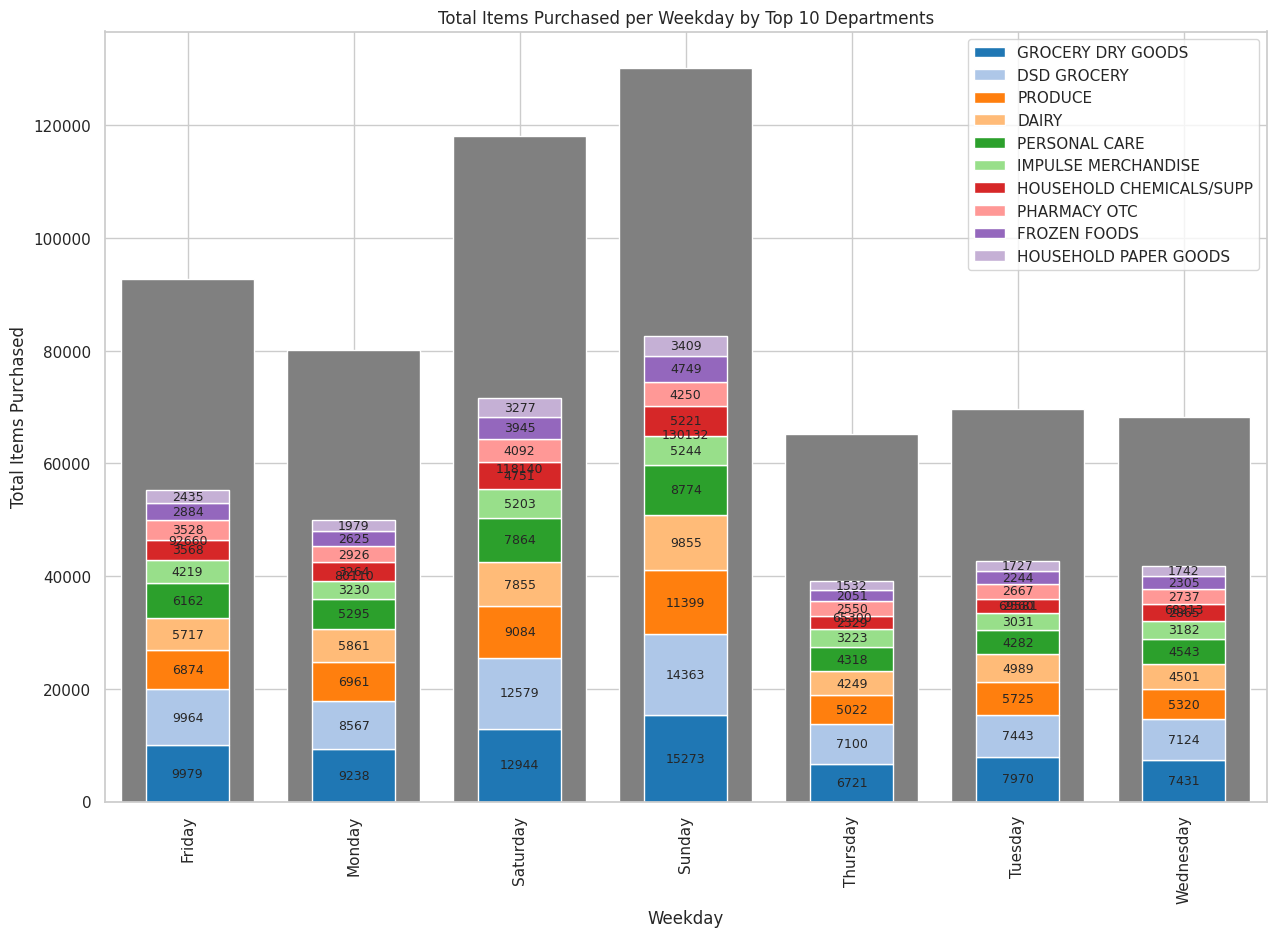

In [ ]:
# Popularity of departments by Total Items
total_items_per_weekday_department = walmart_train.groupBy("Weekday", "DepartmentDescription").agg(count("TotalItems").alias("ItemsPurchased"))

total_items_per_weekday_department = total_items_per_weekday_department.orderBy("ItemsPurchased", ascending=False)

total_items_pd = total_items_per_weekday_department.toPandas()

# Pivot the DataFrame to get 'DepartmentDescription' as columns
items_pivot = total_items_pd.pivot(index='Weekday', columns='DepartmentDescription', values='ItemsPurchased')

# Get the top 10 highest foot traffic departments based on average visits per weekday
top_10_departments = items_pivot.mean().sort_values(ascending=False).head(10).index.tolist()

# Filter the DataFrame to include only the top 10 departments
items_pivot_top_10 = items_pivot[top_10_departments]

# Create the stacked bar chart using Seaborn for the top 10 departments
plt.figure(figsize=(15, 10))  # Adjust the figure size if needed
sns.set_palette("tab20")  # You can use different palettes for different colors
sns.barplot(data=items_pivot, x=items_pivot.index, y=items_pivot.sum(axis=1), color='grey')  # The total visits bar
ax = items_pivot_top_10.plot(kind='bar', stacked=True, ax=plt.gca())  # The stacked bars for the top 10 departments

# Adding labels and title
plt.xlabel('Weekday')
plt.ylabel('Total Items Purchased')
plt.title('Total Items Purchased per Weekday by Top 10 Departments')

# Show the plot
plt.legend(loc='upper right')  # Add a legend for the departments
# Adding data labels to the stacked bars
for p in ax.patches:
    # Calculate the x and y coordinates for the text annotation
    x = p.get_x() + p.get_width() / 2
    y = p.get_y() + p.get_height() / 2
    value = int(p.get_height())  # Get the height (value) of the bar and convert to an integer

    # Add the text annotation
    ax.annotate(value, (x, y), ha='center', va='center', fontsize=9)
plt.show()


##***Correlation between Triptypes and Weekdays***

Pivot Table:
 Weekday    Friday   Monday  Saturday   Sunday  Thursday  Tuesday  Wednesday
TripType                                                                   
3          1406.0    829.0    1168.0    901.0     760.0    859.0      896.0
4           152.0    110.0     163.0    148.0     105.0     96.0      119.0
5          2000.0   1663.0    2182.0   1703.0    1662.0   1685.0     1785.0
6           649.0    333.0     849.0    441.0     376.0    343.0      381.0
7          3222.0   3283.0    3550.0   3991.0    2855.0   2956.0     3222.0
8          3548.0   3106.0    3602.0   3686.0    2887.0   2992.0     2889.0
9          2748.0   2014.0    3143.0   2936.0    2021.0   1797.0     2024.0
12          294.0    206.0     662.0    548.0      92.0    182.0      113.0
14            7.0     14.0      13.0      NaN       NaN      NaN        NaN
15         1478.0    638.0    1482.0   1116.0     943.0    631.0      797.0
18          585.0    348.0     693.0    601.0     196.0    262.0      260.

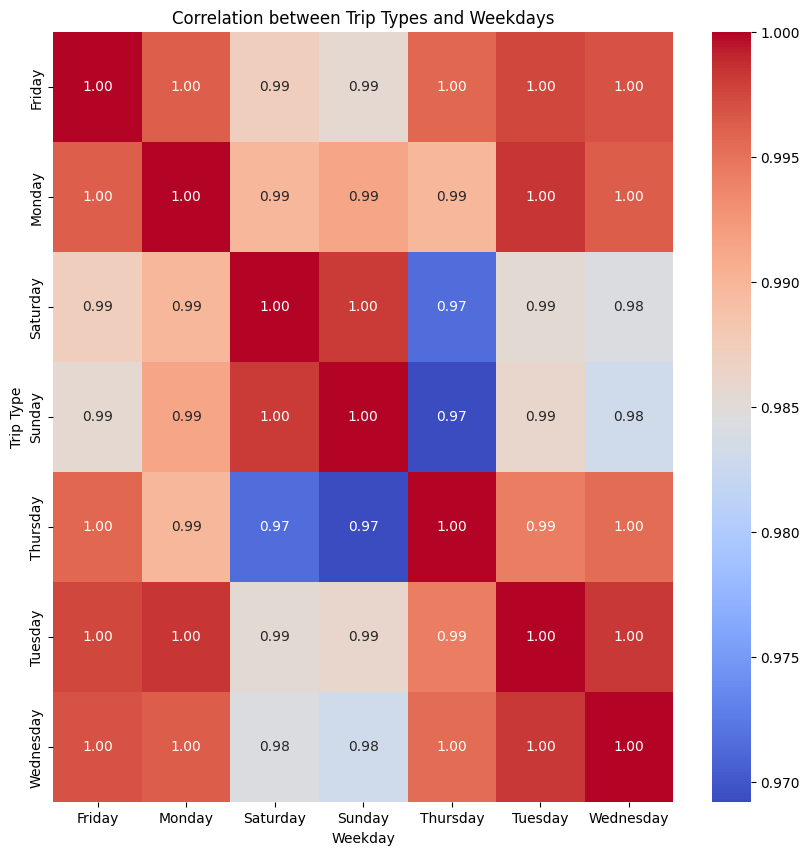

In [ ]:
# Create pivot table for TripType vs Weekday
pivot_table = walmart_train.groupBy("TripType", "Weekday").count().toPandas().pivot(index='TripType', columns='Weekday', values='count')

# Compute correlation matrix
correlation_matrix = pivot_table.corr()

# Plot heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation between Trip Types and Weekdays')
plt.xlabel('Weekday')
plt.ylabel('Trip Type')

# Print results
print("Pivot Table:\n", pivot_table)
print("Correlation Matrix:\n", correlation_matrix)

###***Visualising Numeric Columns using Pair Plot***

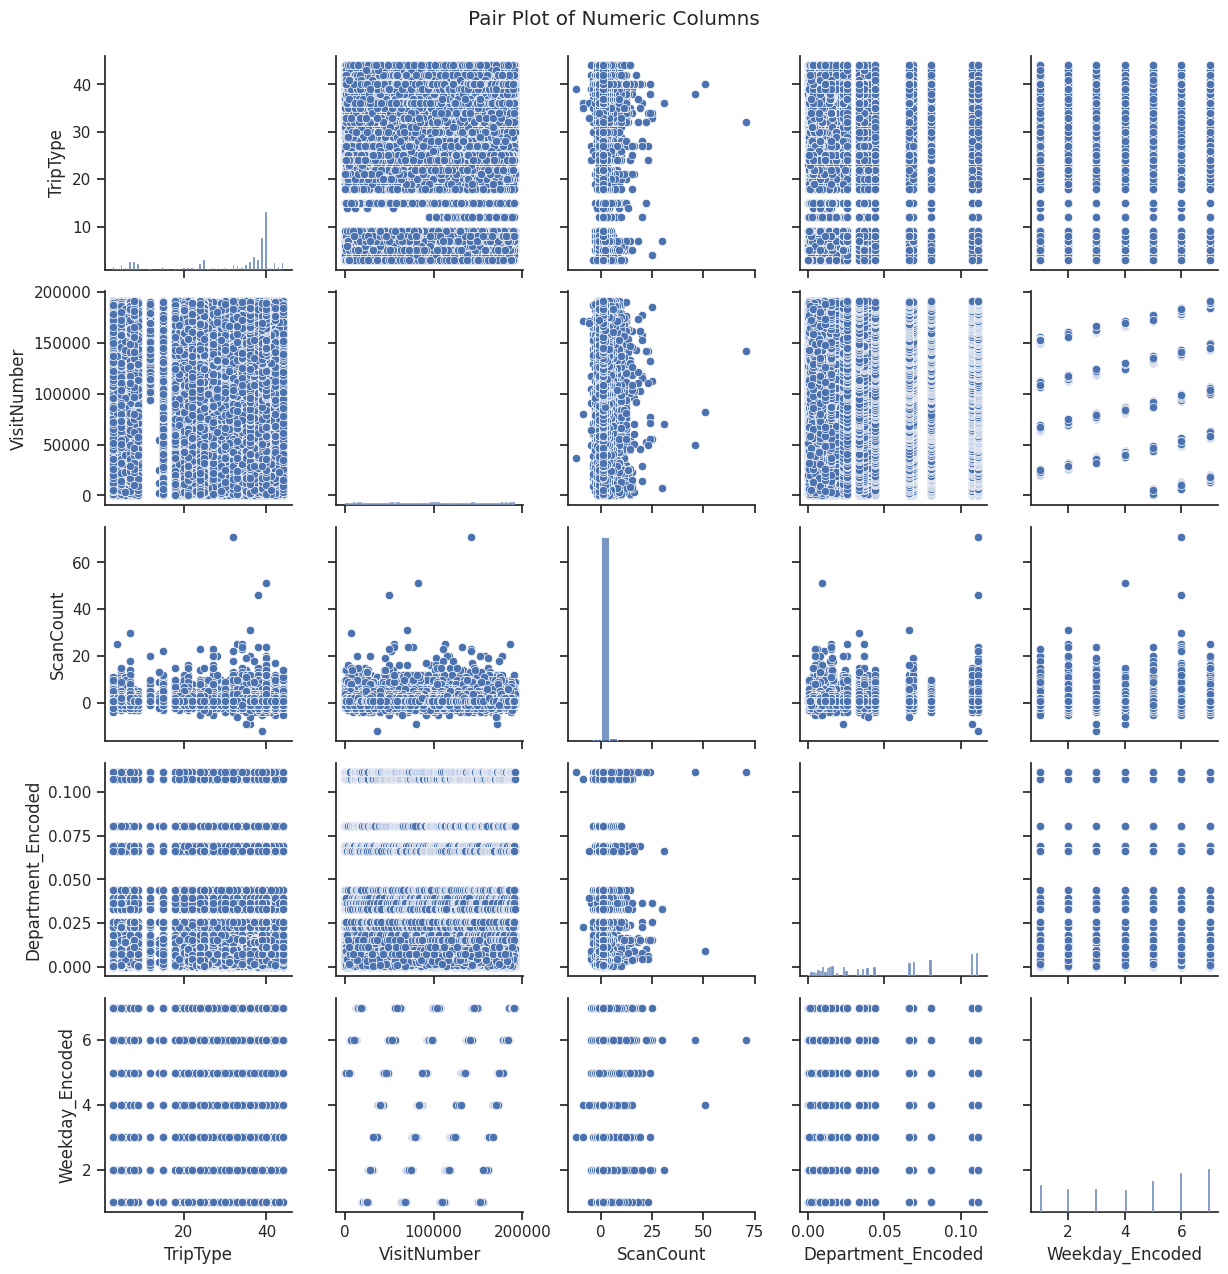

In [ ]:
# Select numeric columns for pair plot
numeric_columns = ['TripType', 'VisitNumber', 'ScanCount', 'Department_Encoded', 'Weekday_Encoded']

# Convert selected numeric columns to Pandas DataFrame
walmart_train_pd = walmart_train.select(numeric_columns).toPandas()

# Pair plot
sns.set(style='ticks')
sns.pairplot(walmart_train_pd)
plt.suptitle("Pair Plot of Numeric Columns", y=1.02)
plt.show()


In [ ]:
# Display the first 10 rows of walmart_train
walmart_train.show(10)


+-----------+---------------------+--------+-------+-----------+---------+--------------+--------------------+---------------+----------+-----------+-----------+---------------+-----------------+-------------------+
|VisitNumber|DepartmentDescription|TripType|Weekday|        Upc|ScanCount|FinelineNumber|  Department_Encoded|Weekday_Encoded|TotalItems|ReturnItems|UniqueItems|DepartmentCount|PopularDepartment|DepartmentFrequency|
+-----------+---------------------+--------+-------+-----------+---------+--------------+--------------------+---------------+----------+-----------+-----------+---------------+-----------------+-------------------+
|          9|  IMPULSE MERCHANDISE|       8| Friday| 1070080727|        1|           115|0.043791737698193986|              5|         3|          3|          3|              2|          PRODUCE|                  1|
|          9|              PRODUCE|       8| Friday|       4011|        1|          5501|  0.0807275978312419|              5|         3

## **III. Creating a Baseline Model using Multinomial Logistic Regression**



In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col

# Initialize Spark Session
spark = SparkSession.builder.appName("WalmartTripTypePrediction").getOrCreate()

# Defining input and output columns
input_cols = ['VisitNumber', 'Upc', 'ScanCount', 'FinelineNumber', 'Department_Encoded', 'Weekday_Encoded', 'TotalItems', 'ReturnItems', 'UniqueItems', 'DepartmentCount', 'DepartmentFrequency']
output_col = 'TripType'

# Load dataset (assuming walmart_train is a Spark DataFrame)
# walmart_train = spark.read.csv("path_to_data.csv", header=True, inferSchema=True)

# Assembling features
assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
data = assembler.transform(walmart_train).select("features", col(output_col).alias("label"))

# Train-validation split (80-20 split)
train_data, val_data = data.randomSplit([0.8, 0.2], seed=42)

# Training the baseline model (using multinomial logistic regression)
lr = LogisticRegression(maxIter=1000, regParam=0.0, elasticNetParam=0, family="multinomial")
model = lr.fit(train_data)

# Make predictions on the validation set
y_val_pred = model.transform(val_data)

# Evaluating accuracy
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator_accuracy.evaluate(y_val_pred)

# Evaluating precision
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
precision = evaluator_precision.evaluate(y_val_pred)

# Evaluating recall
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
recall = evaluator_recall.evaluate(y_val_pred)

# Evaluating F1-score
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1_score = evaluator_f1.evaluate(y_val_pred)

print(f"Validation Data Accuracy: {accuracy*100:.2f}%")
print(f"Validation Data Precision: {precision*100:.2f}%")
print(f"Validation Data Recall: {recall*100:.2f}%")
print(f"Validation Data F1-score: {f1_score*100:.2f}%")


'\nfrom pyspark.sql import SparkSession\nfrom pyspark.ml.feature import VectorAssembler\nfrom pyspark.ml.classification import LogisticRegression\nfrom pyspark.ml.evaluation import MulticlassClassificationEvaluator\nfrom pyspark.sql.functions import col\n\n# Initialize Spark Session\nspark = SparkSession.builder.appName("WalmartTripTypePrediction").getOrCreate()\n\n# Defining input and output columns\ninput_cols = [\'VisitNumber\', \'Upc\', \'ScanCount\', \'FinelineNumber\', \'Department_Encoded\', \'Weekday_Encoded\', \'TotalItems\', \'ReturnItems\', \'UniqueItems\', \'DepartmentCount\', \'DepartmentFrequency\']\noutput_col = \'TripType\'\n\n# Load dataset (assuming walmart_train is a Spark DataFrame)\n# walmart_train = spark.read.csv("path_to_data.csv", header=True, inferSchema=True)\n\n# Assembling features\nassembler = VectorAssembler(inputCols=input_cols, outputCol="features")\ndata = assembler.transform(walmart_train).select("features", col(output_col).alias("label"))\n\n# Train-

=> **From the result, our baseline model exhibited pretty poor performance, achieving a validation accuracy only of 47.59%.**

**Result**:

* Validation Data Accuracy: 47.59%

* Validation Data Precision: 35.56%

* Validation Data Recall: 47.59%

* Validation Data F1-score: 37.74%

----------------------------------------

## **IV. Training using Decision Trees and Hyperparameter tuning**

### Training Decision Trees model

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id, col  # Import for adding ID and col

# Initialize Spark Session
spark = SparkSession.builder.appName("DecisionTreeExample").getOrCreate()

# Prepare the training data
# Assuming walmart_train is the original DataFrame
input_cols = ['VisitNumber', 'Upc', 'ScanCount', 'FinelineNumber', 'Department_Encoded', 'Weekday_Encoded', 'TotalItems', 'ReturnItems', 'UniqueItems', 'DepartmentCount', 'DepartmentFrequency']
output_col = 'TripType'

# Create x_train and y_train
assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
data = assembler.transform(walmart_train).select("features", col(output_col).alias("label"))

x_train = data.select("features")  # Select features for x_train
y_train = data.select("label")    # Select label for y_train


# Add a unique ID column to both x_train and y_train
x_train = x_train.withColumn("id", monotonically_increasing_id())
y_train = y_train.withColumn("id", monotonically_increasing_id())

# Now join based on this ID column to create train_df
train_df = x_train.join(y_train, on="id", how="inner").drop("id")

# The rest of your code remains the same...

# Train-validation split
train_df, val_df = train_df.randomSplit([0.8, 0.2], seed=42)

# Assemble feature columns into a single vector column
# The 'features' column already exists, so we'll create a new one called 'assembled_features'
feature_cols = [col_name for col_name in train_df.columns if col_name != "label"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="assembled_features") # Changed outputCol

# Overwrite the 'features' column with the new 'assembled_features' column
train_df = assembler.transform(train_df).select("assembled_features", "label").withColumnRenamed("assembled_features", "features")
val_df = assembler.transform(val_df).select("assembled_features", "label").withColumnRenamed("assembled_features", "features")
# Define the Decision Tree Classifier
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", seed=42)

# Train the model
dt_model = dt.fit(train_df)

# Make predictions
train_predictions = dt_model.transform(train_df)
val_predictions = dt_model.transform(val_df)

# Define Evaluators
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

# Compute Metrics
accuracy_train = evaluator.evaluate(train_predictions)
accuracy_val = evaluator.evaluate(val_predictions)
precision_val = precision_evaluator.evaluate(val_predictions)
recall_val = recall_evaluator.evaluate(val_predictions)
f1_val = f1_evaluator.evaluate(val_predictions)

# Print Results
print(f"Decision Tree Model Accuracy in Training df: {accuracy_train*100:.2f}%")
print(f"Decision Tree Model Accuracy in Validation df: {accuracy_val*100:.7f}%")
print(f"Decision Tree Model Precision in Validation df: {precision_val:.7f}")
print(f"Decision Tree Model Recall in Validation df: {recall_val:.7f}")
print(f"Decision Tree Model F1-Score in Validation df: {f1_val:.7f}")


Decision Tree Model Accuracy in Training df: 29.27%
Decision Tree Model Accuracy in Validation df: 27.9931094%
Decision Tree Model Precision in Validation df: 0.1101298
Decision Tree Model Recall in Validation df: 0.2799311
Decision Tree Model F1-Score in Validation df: 0.1369574


Result:

Decision Tree Model Accuracy in Training df: 29.27%

Decision Tree Model Accuracy in Validation df: 27.9931094%

Decision Tree Model Precision in Validation df: 0.1101298

Decision Tree Model Recall in Validation df: 0.2799311

Decision Tree Model F1-Score in Validation df: 0.1369574

**Extract Important Features from the model**

                feature  importance
4    Department_Encoded    0.195722
9       DepartmentCount    0.189369
10  DepartmentFrequency    0.134966
8           UniqueItems    0.127440
1                   Upc    0.120344
3        FinelineNumber    0.091633
6            TotalItems    0.069863
0           VisitNumber    0.047282
2             ScanCount    0.023381
5       Weekday_Encoded    0.000000


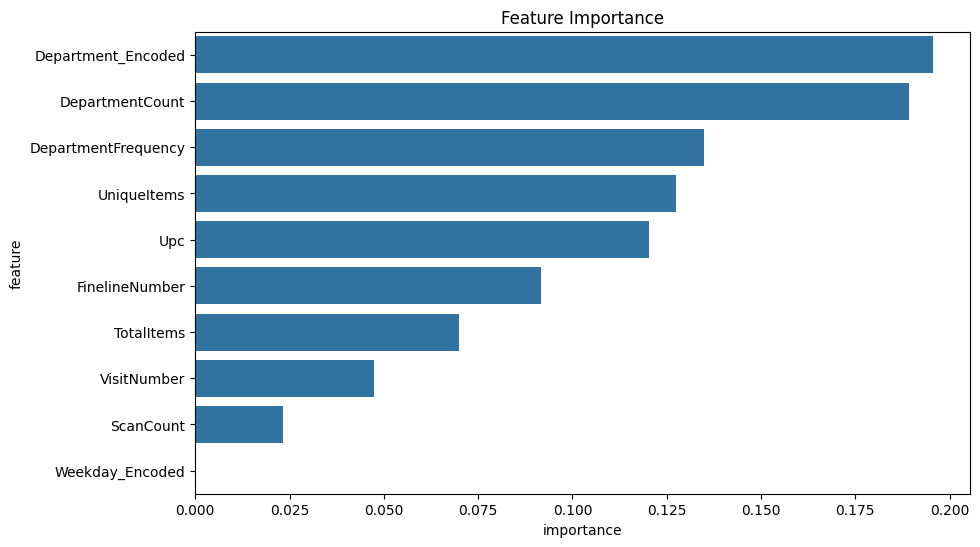

In [ ]:
# Extract feature importances
feature_importance = dt_model.featureImportances.toArray()
importance_df = pd.DataFrame({
    'feature': input_cols,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature')
plt.show()


**From the graph we can see top 5 important features are 'Department_Encoded', 'DepartmentCount', 'DepartmentFrequency', 'UniqueItems' and 'Upc'**

## Optimizing Decision Trees through Hyperparameter Refinement



Hyperparameters are settings in a machine learning model that are set before training and influence how the learning algorithm operates. Unlike model parameters, they are not learned during training but are specified by the user or data scientist. In the decision tree model mentioned, the key hyperparameters to adjust include: **max_depths, min_samples_leaf, max_features, min_samples_split, and criterion**.

We will now manually examine how these hyperparameters impact the validation accuracy.

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id, col  # Import for adding ID and col

# Initialize Spark session
spark = SparkSession.builder.appName("DecisionTreeTuning").getOrCreate()

# Choose top 5 important features
feature_cols = ['Department_Encoded', 'DepartmentCount', 'DepartmentFrequency', 'UniqueItems', 'Upc']
output_col = 'TripType'

# Assemble features into a single vector column
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
train_transformed = vector_assembler.transform(walmart_train).select('features', 'TripType')

# Assemble features into a single vector column
# Select a subset of features (e.g., top 5 most important features)
selected_features = importance_df.head(5)['feature'].tolist()  # Replace with your feature selection method
vector_assembler = VectorAssembler(inputCols=selected_features, outputCol='features')
walmart_train_transformed = vector_assembler.transform(walmart_train).select('features', 'TripType')

# Train-validation split
train_split, val_split = walmart_train_transformed.randomSplit([0.8, 0.2], seed=42)
train_split = train_split.sample(fraction=0.5, seed=42)  # Using 50% of training data

def test_params_dt(**params):
    # Create and train model
    dt = DecisionTreeClassifier(featuresCol="features", labelCol="TripType", **params)
    model = dt.fit(train_split)

    # Make predictions
    train_pred = model.transform(train_split)
    val_pred = model.transform(val_split)

    # Evaluate accuracy
    evaluator = MulticlassClassificationEvaluator(labelCol="TripType", predictionCol="prediction", metricName="accuracy")
    train_acc = evaluator.evaluate(train_pred)
    val_acc = evaluator.evaluate(val_pred)

    return train_acc, val_acc

In [ ]:
print(f"Parameter max_depth = 6 gives accuracy:", test_params_dt(maxDepth=6))
print("Parameter criterion = 'entropy' gives accuracy:", test_params_dt(impurity='entropy'))
print("Parameter min_samples_split = 2 gives accuracy:", test_params_dt(minInstancesPerNode=5))
print("Parameter min_samples_leaf = 2 gives accuracy:", test_params_dt(minInfoGain=5))
print("Parameter max_features = None gives accuracy:", test_params_dt())
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
print("Final Tuned accuracy for decision tree:", test_params_dt(maxDepth=6, impurity='entropy', minInstancesPerNode=5, minInfoGain=5))

Parameter max_depth = 6 gives accuracy: (0.49363648734101223, 0.49469331605761774)
Parameter criterion = 'entropy' gives accuracy: (0.47136819524377455, 0.4716030424454735)
Parameter min_samples_split = 2 gives accuracy: (0.4752063138852647, 0.47619390391182986)
Parameter min_samples_leaf = 2 gives accuracy: (0.27672074985391937, 0.27757916036822866)
Parameter max_features = None gives accuracy: (0.4752063138852647, 0.47619390391182986)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Final Tuned accuracy for decision tree: (0.27672074985391937, 0.27757916036822866)


**Result**
* Parameter max_depth = 6 gives accuracy: (0.49363648734101223, 0.49469331605761774)
* Parameter criterion = 'entropy' gives accuracy: (0.47136819524377455, 0.4716030424454735)
* Parameter min_samples_split = 2 gives accuracy: (0.4752063138852647, 0.47619390391182986)
* Parameter min_samples_leaf = 2 gives accuracy: (0.27672074985391937, 0.27757916036822866)
* Parameter max_features = None gives accuracy: (0.4752063138852647, 0.47619390391182986)
--------------------------------------------------------------------------

* Final Tuned accuracy for decision tree: (0.27672074985391937, 0.27757916036822866) ~ 27.76 %


**As observed above, our decision trees model exhibited low performance, achieving a validation accuracy of only 27.76:%.**

## Hyperparameter tunining with Decision Tree using TrainValidationSplit

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.sql.functions import col

# Select top features
feature_cols = ['Department_Encoded', 'DepartmentCount', 'DepartmentFrequency', 'UniqueItems', 'Upc']
output_col = 'TripType'

# Assemble features
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
walmart_train_transformed = vector_assembler.transform(walmart_train).select('features', 'TripType').cache()

# Train-validation split
train_split, val_split = walmart_train_transformed.randomSplit([0.8, 0.2], seed=42)

# Reduce dataset size for faster tuning
train_split = train_split.sample(fraction=0.3, seed=42)  # 30% of training data

# Reduce shuffle partitions
spark.conf.set("spark.sql.shuffle.partitions", "100")

# Define DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(labelCol='TripType', featuresCol='features', seed=42)

# Define optimized parameter grid
param_grid = (ParamGridBuilder()
    .addGrid(dt_classifier.maxDepth, [5, 10])   # Tune max depth
    .addGrid(dt_classifier.minInstancesPerNode, [1, 2])  # Tune min instances per node
    .build())

# Define evaluator
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol='TripType', predictionCol='prediction', metricName='accuracy')

# Use TrainValidationSplit with lower parallelism
train_validation_split = TrainValidationSplit(
    estimator=dt_classifier,
    estimatorParamMaps=param_grid,
    evaluator=evaluator_accuracy,
    trainRatio=0.8,  # 80% train, 20% validation
    seed=42,
    parallelism=2  # Reduce parallel jobs to avoid excessive resource usage
)

# Train the model
tv_model = train_validation_split.fit(train_split)

# Get best model
best_model = tv_model.bestModel

# Evaluate on validation set
val_predictions = best_model.transform(val_split)
val_accuracy = evaluator_accuracy.evaluate(val_predictions)

print("Best model parameters:")
print("maxDepth:", best_model.getMaxDepth())
print("minInstancesPerNode:", best_model.getMinInstancesPerNode())
print("Validation Accuracy:", val_accuracy)


Best model parameters:
maxDepth: 10
minInstancesPerNode: 1
Validation Accuracy: 0.5341342914888839


**Result:**

Best Decision Tree Model Accuracy: 53.41%



***Observation***:

* Original Validation accuracy: 27.76%
* TrainValidationSplit - Validation accuracy: 53.41%



TrainValidationSplit  have led to an improvement in the model's accuracy compared to the original accuracy. This indicates that tuning the hyperparameters has enhanced the decision tree model's ability to capture patterns and make better predictions on the validation set. This suggests that TrainValidationSplit's random sampling of hyperparameters has been effective in finding a combination that performs well on your specific dataset.

##**V. Training using Random Forest**

A random forest is a machine learning algorithm that improves decision-making by aggregating the outputs of numerous decision trees. It builds an ensemble of trees, each trained on a distinct subset of the data. By merging the predictions from these individual trees, the random forest achieves greater accuracy and robustness than a single decision tree.

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

# Assuming 'walmart_train' is already a PySpark DataFrame
# Define feature columns and target column
feature_cols = ['VisitNumber', 'Upc', 'ScanCount', 'FinelineNumber', 'Department_Encoded', 'Weekday_Encoded', 'TotalItems', 'ReturnItems', 'UniqueItems', 'DepartmentCount', 'DepartmentFrequency']  # Adjust 'TripType' as per your dataset

# Assemble features into a single vector column
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
train_transformed = vector_assembler.transform(walmart_train).select('features', 'TripType')

# Train-validation split
train_split, val_split = train_transformed.randomSplit([0.8, 0.2], seed=42)

# Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier(labelCol='TripType', featuresCol='features', seed=42)

# Train the model
rf_model = rf_classifier.fit(train_split)

# Make predictions
train_predictions = rf_model.transform(train_split)
val_predictions = rf_model.transform(val_split)

# Initialize evaluators
evaluator = MulticlassClassificationEvaluator(labelCol='TripType', predictionCol='prediction', metricName='accuracy')
precision_evaluator = MulticlassClassificationEvaluator(labelCol='TripType', predictionCol='prediction', metricName='weightedPrecision')
recall_evaluator = MulticlassClassificationEvaluator(labelCol='TripType', predictionCol='prediction', metricName='weightedRecall')
f1_evaluator = MulticlassClassificationEvaluator(labelCol='TripType', predictionCol='prediction', metricName='f1')

# Calculate metrics
accuracy_train = evaluator.evaluate(train_predictions)
accuracy_val = evaluator.evaluate(val_predictions)
precision_val = precision_evaluator.evaluate(val_predictions)
recall_val = recall_evaluator.evaluate(val_predictions)
f1_val = f1_evaluator.evaluate(val_predictions)

# Print results
print(f"Random Forest Model Accuracy in Training df: {accuracy_train*100:.2f}%")
print(f"Random Forest Model Accuracy in Validation df: {accuracy_val*100:.7f}%")
print(f"Random Forest Model Precision in Validation df: {precision_val:.7f}")
print(f"Random Forest Model Recall in Validation df: {recall_val:.7f}")
print(f"Random Forest Model F1-Score in Validation df: {f1_val:.7f}")


Random Forest Model Accuracy in Training df: 48.69%
Random Forest Model Accuracy in Validation df: 48.8742792%
Random Forest Model Precision in Validation df: 0.3044503
Random Forest Model Recall in Validation df: 0.4887428
Random Forest Model F1-Score in Validation df: 0.3576351


**Code result:**


* Random Forest Model Accuracy in Training df: 48.69%
* Random Forest Model Accuracy in Validation df: 48.8742792%
* Random Forest Model Precision in Validation df: 0.3044503
* Random Forest Model Recall in Validation df: 0.4887428
* Random Forest Model F1-Score in Validation df: 0.3576351

=> Random Forests achieve a validation accuracy of 48.87%, outperforming Decision Trees (27.76%) while not using hyperparameter tuning. This enhancement indicates that their ensemble approach helps mitigate overfitting, captures a wider range of patterns, and increases model robustness. While interpretability may be reduced, the trade-off between accuracy and interpretability leans in favor of Random Forests.

Next, we aim to further improve the validation accuracy of Random Forests through hyperparameter tuning. But first we will need to extract importanct features:

                feature  importance
7           ReturnItems    0.349546
6            TotalItems    0.268843
8           UniqueItems    0.167977
4    Department_Encoded    0.082049
9       DepartmentCount    0.079144
1                   Upc    0.021383
10  DepartmentFrequency    0.018641
3        FinelineNumber    0.012330
0           VisitNumber    0.000041
2             ScanCount    0.000030


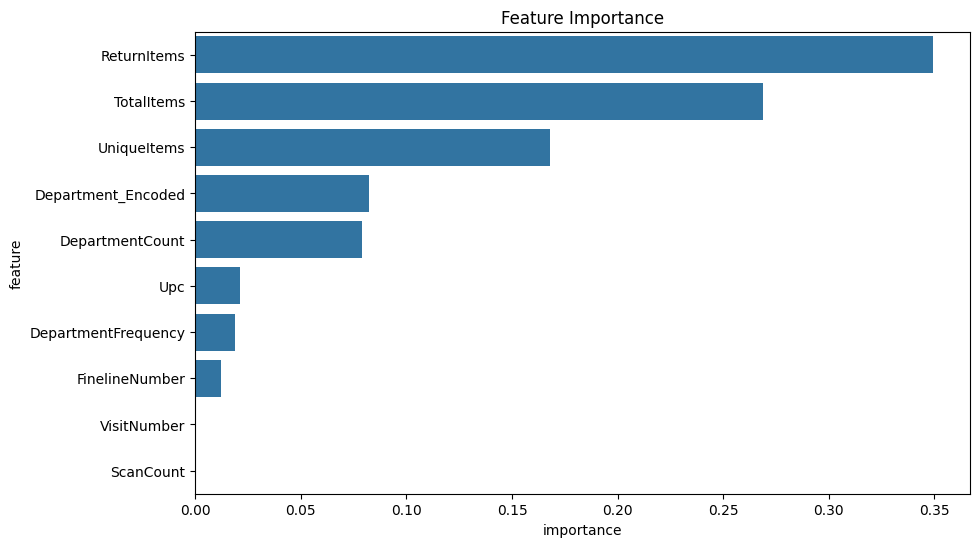

In [ ]:
# Extract feature importances
feature_importance = rf_model.featureImportances.toArray()
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature')
plt.show()

**The top 5 features are 'ReturnItems', 'TotalItems', 'UniqueItems', 'Department_Encoded'and 'DepartmentCount'**

## Optimizing Random Forests through Hyperparameter Refinement

Let's search through different hyperparameters to optimize the Random Forest model performance using manual trial and error and then tune using TrainValidationSplit.

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
# from pyspark.sql import SparkSession  # Import SparkSession

# Initialize Spark session if it's not already initialized
# spark = SparkSession.builder.appName("WalmartTripTypePrediction").getOrCreate()

# Assuming 'walmart_train' is already a PySpark DataFrame
feature_cols = ['ReturnItems', 'TotalItems', 'UniqueItems', 'Department_Encoded', 'DepartmentCount']
output_col = 'TripType'

# Assemble features into a single vector column
# Select a subset of features (e.g., top 5 most important features)
selected_features = importance_df.head(5)['feature'].tolist()  # Replace with your feature selection method
vector_assembler = VectorAssembler(inputCols=selected_features, outputCol='features')
walmart_train_transformed = vector_assembler.transform(walmart_train).select('features', 'TripType')

# Train-validation split
train_split, val_split = walmart_train_transformed.randomSplit([0.8, 0.2], seed=42)
train_split = train_split.sample(fraction=0.5, seed=42)  # Using 50% of training data


def test_params_rf(**params):
    rf_classifier = RandomForestClassifier(labelCol='TripType', featuresCol='features', seed=42, **params)
    rf_model = rf_classifier.fit(train_split)
    train_predictions = rf_model.transform(train_split)
    val_predictions = rf_model.transform(val_split)

    evaluator = MulticlassClassificationEvaluator(labelCol='TripType', predictionCol='prediction', metricName='accuracy')
    return evaluator.evaluate(train_predictions), evaluator.evaluate(val_predictions)

print("Parameter maxDepth = 8 gives accuracy:", test_params_rf(maxDepth=8))
print("Parameter impurity = 'entropy' gives accuracy:", test_params_rf(impurity='entropy'))
print("Parameter minInstancesPerNode = 5 gives accuracy:", test_params_rf(minInstancesPerNode=5))
print("Parameter minInfoGain = 0.01 gives accuracy:", test_params_rf(minInfoGain=0.01))
print("Parameter numTrees = 30 gives accuracy:", test_params_rf(numTrees=30))
print("Parameter featureSubsetStrategy = 'auto' gives accuracy:", test_params_rf(featureSubsetStrategy='auto'))
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
print("Final Tuned accuracy for random forest:", test_params_rf(maxDepth=8, impurity='entropy', minInstancesPerNode=5, minInfoGain=0.01, numTrees=30, featureSubsetStrategy='auto'))


Parameter maxDepth = 8 gives accuracy: (0.5249800855819613, 0.5250789842031593)
Parameter impurity = 'entropy' gives accuracy: (0.486884504381172, 0.4890861827634473)
Parameter minInstancesPerNode = 5 gives accuracy: (0.4856235914802317, 0.4876704659068186)
Parameter minInfoGain = 0.01 gives accuracy: (0.48436668147738965, 0.4866386722655469)
Parameter numTrees = 30 gives accuracy: (0.4910034865242435, 0.4938452309538092)
Parameter featureSubsetStrategy = 'auto' gives accuracy: (0.4856235914802317, 0.4876704659068186)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Final Tuned accuracy for random forest: (0.5307562675376973, 0.5312777444511098)


**Conclusion:**

=> Validation accuracy (53.13%) is close to training accuracy (53.07%), indicating low overfitting.
The model's accuracy is relatively low, meaning feature selection or model choice may need improvement.

## **Hyperparameter tuning using Spark's TrainValidationSplit**

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.sql.functions import col

# Select top features
feature_cols = ['ReturnItems', 'TotalItems', 'UniqueItems', 'Department_Encoded', 'DepartmentCount']
output_col = 'TripType'

# Assemble features
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
walmart_train_transformed = vector_assembler.transform(walmart_train).select('features', 'TripType').cache()  # Cache to speed up transformations

# Train-validation split
train_split, val_split = walmart_train_transformed.randomSplit([0.8, 0.2], seed=42)

# Reduce dataset size for faster tuning
train_split = train_split.sample(fraction=0.3, seed=42)  # 30% of training data

# Reduce shuffle partitions
spark.conf.set("spark.sql.shuffle.partitions", "100")

# Define RandomForestClassifier
rf_classifier = RandomForestClassifier(labelCol='TripType', featuresCol='features', seed=42)

# Define optimized parameter grid
param_grid = (ParamGridBuilder()
    .addGrid(rf_classifier.maxDepth, [5, 10])   # Lower max depth
    .addGrid(rf_classifier.numTrees, [20, 50])  # Fewer trees
    .addGrid(rf_classifier.minInstancesPerNode, [1])  # Fixed value for simplicity
    .build())

# Define evaluator
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol='TripType', predictionCol='prediction', metricName='accuracy')

# Use TrainValidationSplit with lower parallelism
train_validation_split = TrainValidationSplit(
    estimator=rf_classifier,
    estimatorParamMaps=param_grid,
    evaluator=evaluator_accuracy,
    trainRatio=0.8,  # 80% train, 20% validation
    seed=42,
    parallelism=2  # Reduce parallel jobs to avoid excessive resource usage
)

# Train the model
tv_model = train_validation_split.fit(train_split)

# Get best model
best_model = tv_model.bestModel

# Evaluate on validation set
val_predictions = best_model.transform(val_split)
val_accuracy = evaluator_accuracy.evaluate(val_predictions)

print("Best model parameters:")
print("maxDepth:", best_model.getMaxDepth())
print("numTrees:", best_model.getNumTrees)
print("minInstancesPerNode:", best_model.getMinInstancesPerNode())
print("Validation Accuracy:", val_accuracy)


Best model parameters:
maxDepth: 10
numTrees: 50
minInstancesPerNode: 1
Validation Accuracy: 0.5416082712005574


In [ ]:
# Evaluate additional metrics
evaluator_precision = MulticlassClassificationEvaluator(labelCol='TripType', predictionCol='prediction', metricName='weightedPrecision')
evaluator_recall = MulticlassClassificationEvaluator(labelCol='TripType', predictionCol='prediction', metricName='weightedRecall')
evaluator_f1 = MulticlassClassificationEvaluator(labelCol='TripType', predictionCol='prediction', metricName='f1')

# Compute values
precision_val = evaluator_precision.evaluate(val_predictions)
recall_val = evaluator_recall.evaluate(val_predictions)
f1_val = evaluator_f1.evaluate(val_predictions)

print(f"Validation Precision: {precision_val:.7f}")
print(f"Validation Recall: {recall_val:.7f}")
print(f"Validation F1-Score: {f1_val:.7f}")

Validation Precision: 0.5282450
Validation Recall: 0.5416083
Validation F1-Score: 0.4684936


***Observations***:

* Original Validation accuracy: 53.13%
* TrainValidationSplit — Validation accuracy: 54.16%


As observed above, TrainValidationSplit have performed slightly better than what we had observed before tuning random forests. However, the accuracy is still far too low the acceptant level

# **VI. Training using XGBoost**

XGBoost (Extreme Gradient Boosting) is a powerful and scalable machine learning algorithm based on the gradient boosting framework. It is designed for efficiency, performance, and accuracy, particularly in structured or tabular data. XGBoost builds an ensemble of decision trees sequentially, where each new tree corrects the errors of the previous ones. It optimizes a loss function using gradient descent and incorporates regularization to prevent overfitting. Known for its speed and high performance, XGBoost is widely used in competitions (e.g., Kaggle) and real-world applications for tasks like classification, regression, and ranking.

**Important Note**:

Firstly, I will train the dataset on pure XGBoost (without PySpark) to figure out the result first.

I will try run XGBoost again on PySpark to check if we can get the same result of accuracy as not running in Spark.

## Traing pure XGBoost on Pandas

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Sample 10000 rows at a time (adjust as needed)
batch_size = 10000
pandas_train = walmart_train.limit(batch_size).toPandas()

# Define features and target
feature_cols = ['VisitNumber', 'Upc', 'ScanCount', 'FinelineNumber', 'Department_Encoded', 'Weekday_Encoded',
                'TotalItems', 'ReturnItems', 'UniqueItems', 'DepartmentCount', 'DepartmentFrequency']
X = pandas_train[feature_cols]
y = pandas_train['TripType']

# Split the data before encoding
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Label encoding AFTER splitting
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Fit on train labels
y_test_encoded = label_encoder.transform(y_test)  # Transform test labels

# Convert to XGBoost DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train_encoded)
dtest = xgb.DMatrix(X_test, label=y_test_encoded)

# Check label encoding ranges
print("Unique y_train_encoded:", set(y_train_encoded))
print("Unique y_test_encoded:", set(y_test_encoded))
print("Expected range: 0 to", len(label_encoder.classes_) - 1)

# Set XGBoost parameters
param = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'multi:softmax',
    'num_class': len(label_encoder.classes_)  # Number of unique classes
}
num_round = 20

# Train the XGBoost model
bst = xgb.train(param, dtrain, num_round)

# Make predictions
preds = bst.predict(dtest)

# Decode predictions back to original TripType values
decoded_preds = label_encoder.inverse_transform(preds.astype(int))

# Evaluate accuracy
accuracy = accuracy_score(y_test, decoded_preds)
print('\n')
print("Model Accuracy:", accuracy)


Unique y_train_encoded: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34}
Unique y_test_encoded: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34}
Expected range: 0 to 34


Model Accuracy: 0.744


**Result before tuning:**

* **Model Accuracy**: 0.744 ~ 74.4%


---------------------------------------

 ## Pure XGBoost Hyperparameter Tuning with GridSearchCV

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Convert PySpark DataFrame to Pandas (sampling for performance)
batch_size = 10000
pandas_train = walmart_train.limit(batch_size).toPandas()

# Define features and target
feature_cols = ['VisitNumber', 'Upc', 'ScanCount', 'FinelineNumber', 'Department_Encoded', 'Weekday_Encoded',
                'TotalItems', 'ReturnItems', 'UniqueItems', 'DepartmentCount', 'DepartmentFrequency']
X = pandas_train[feature_cols]
y = pandas_train['TripType']

# Train-test split before encoding
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Label encoding AFTER splitting
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Fit on train labels
y_test_encoded = label_encoder.transform(y_test)  # Transform test labels

# Create an XGBoost model
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(label_encoder.classes_), use_label_encoder=False)

# Define parameter grid
param_grid = {
    'max_depth': [3, 6, 9],        # Tree depth
    'learning_rate': [0.01, 0.1, 0.3],  # Step size
    'n_estimators': [50, 100, 200],  # Number of boosting rounds
    'subsample': [0.8, 1],          # % of samples used per tree
    'colsample_bytree': [0.8, 1]    # % of features used per tree
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train_encoded)

# Best parameters and best model
print("Best Parameters:", grid_search.best_params_)
best_model_p = grid_search.best_estimator_

# Evaluate the best model
preds = best_model_p.predict(X_test)
decoded_preds = label_encoder.inverse_transform(preds)

accuracy = accuracy_score(y_test, decoded_preds)
print("Tuned Model Accuracy:", accuracy)


Fitting 3 folds for each of 108 candidates, totalling 324 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:52:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 200, 'subsample': 1}
Tuned Model Accuracy: 0.919


**Result after tuning**:

* **Best Parameters**: {'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 200, 'subsample': 1}

* **Tuned Model Accuracy**: 0.919 ~ 91.9%

**Difference after tuning: 17.5%**

----------------------------------------------------

## Train XGBoost with PySpark

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

# Assemble features
feature_cols = ['VisitNumber', 'Upc', 'ScanCount', 'FinelineNumber', 'Department_Encoded',
                'Weekday_Encoded', 'TotalItems', 'ReturnItems', 'UniqueItems',
                'DepartmentCount', 'DepartmentFrequency']

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
walmart_train_transformed = assembler.transform(walmart_train)

# Convert to Pandas for XGBoost
pandas_train = walmart_train_transformed.select("features", "TripType").toPandas()

# ***CHANGE***: Access the features from the 'features' column
X = pandas_train['features'].apply(pd.Series) # Extract features from the 'features' column
X = X.rename(columns=dict(enumerate(feature_cols))) # Rename columns to original feature names
y = pandas_train['TripType']

# ***CHANGE***: Ensure labels are in the range [0, num_class-1]
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)  # Convert labels to sequential integers starting from 0

# Now proceed with the XGBoost model as before
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

param = {'max_depth': 6, 'eta': 0.1, 'objective': 'multi:softmax', 'num_class': len(le.classes_)} # Use len(le.classes_) instead of len(y.unique())
num_round = 20
bst = xgb.train(param, dtrain, num_round)

# Make predictions
preds = bst.predict(dtest)

# Evaluate predictions
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, preds)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6030297689620918


**Result before tuning**:
* **Accuracy**: 0.6030297689620918 ~ 60.3%


## PySpark XGBoost Hyperparameter tuning with GridSearchCV

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

# Assemble features
feature_cols = ['VisitNumber', 'Upc', 'ScanCount', 'FinelineNumber', 'Department_Encoded',
                'Weekday_Encoded', 'TotalItems', 'ReturnItems', 'UniqueItems',
                'DepartmentCount', 'DepartmentFrequency']

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
walmart_train_transformed = assembler.transform(walmart_train)

# Convert to Pandas for XGBoost
pandas_train = walmart_train_transformed.select("features", "TripType").toPandas()

# Access the features from the 'features' column
X = pandas_train['features'].apply(pd.Series)  # Extract features from the 'features' column
X = X.rename(columns=dict(enumerate(feature_cols)))  # Rename columns to original feature names
y = pandas_train['TripType']

# Ensure labels are in the range [0, num_class-1]
le = LabelEncoder()
y = le.fit_transform(y)  # Convert labels to sequential integers starting from 0

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define XGBoost parameters for grid search
param_grid = {
    'max_depth': [3, 6],         # Depth of trees
    'eta': [0.1, 0.3],        # Learning rate
    'subsample': [0.8],         # Fraction of training data used for each boosting round
    'colsample_bytree': [1],  # Fraction of features used for each boosting round
    'n_estimators': [100, 200]   # Number of boosting rounds
}

# Set up the XGBoost model
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(le.classes_), n_jobs=1)

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy', verbose=1)

# Train the model with the best hyperparameters from the grid search
grid_search.fit(X_train, y_train)

# Best hyperparameters from grid search
print("Best Hyperparameters found: ", grid_search.best_params_)

# Evaluate the best model from grid search on the test data
best_model = grid_search.best_estimator_
preds = best_model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, preds)
print(f"Accuracy with Best Hyperparameters: {accuracy}")


Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Hyperparameters found:  {'colsample_bytree': 1, 'eta': 0.3, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
Accuracy with Best Hyperparameters: 0.7115791328868523


* **Best Hyperparameters found**:  {'colsample_bytree': 1, 'eta': 0.3, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}

* **Accuracy after tuning with Best Hyperparameters**: 0.7115791328868523 ~ 71.16%


**Accuracy difference after tuning: 10.86%**

**Sub-Conclusion**

* Pure XGBoost on Pandas seems to have better accuracy while not training in PySpark. However, with larger dataset (GB), PySpark may perform better.


**Save the model for future use**

In [ ]:
import xgboost as xgb
import joblib

# Save model using XGBoost's built-in method
best_model.save_model("best_xgboost_model.json")

# Alternative: Save using joblib (works for GridSearchCV models)
joblib.dump(best_model, "best_xgboost_model.pkl")

# Move to Google Drive (optional, so it's not lost when Colab restarts)
from google.colab import drive
drive.mount('/content/drive')
!mv best_xgboost_model.json /content/drive/MyDrive/
!mv best_xgboost_model.pkl /content/drive/MyDrive/


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **VII. Final Findings**

###  Model Accuracy comparison graph

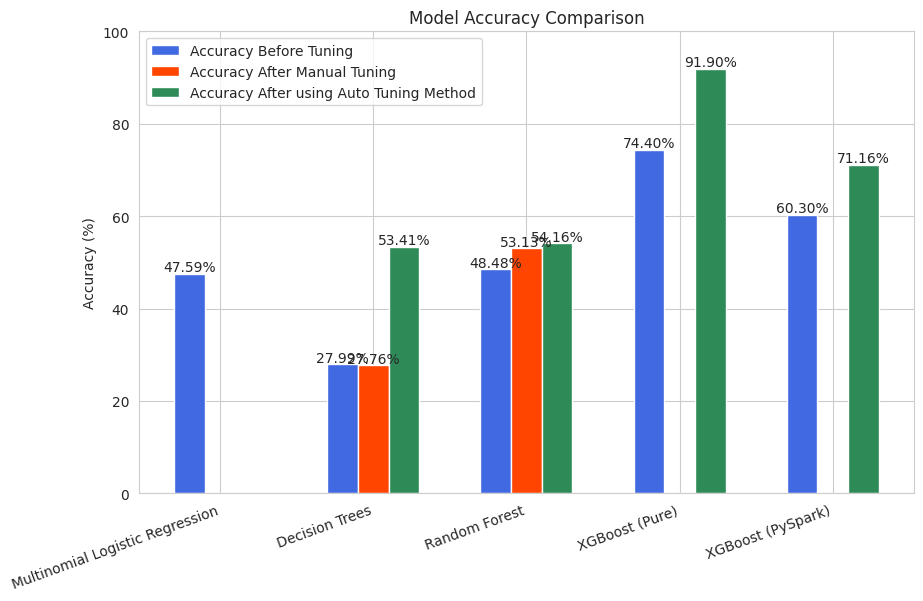

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data
models = ['Multinomial Logistic Regression', 'Decision Trees', 'Random Forest', 'XGBoost (Pure)', "XGBoost (PySpark)"]
accuracy_before_tuning = [47.59, 27.99, 48.48, 74.4, 60.3]  # Before tuning
accuracy_manual_tuning = [None, 27.76, 53.13, None, None]  # Manual tuning (None means no manual tuning for Logistic Regression)
accuracy_tvs_tuning = [None, 53.41, 54.16, 91.9, 71.16]  # TrainValidationSplit tuning


# Bar width
bar_width = 0.2
x = np.arange(len(models))

# Plot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Bars
bars1 = plt.bar(x - bar_width, accuracy_before_tuning, width=bar_width, label="Accuracy Before Tuning", color='royalblue')
# Replace None with 0 for plotting
accuracy_manual_tuning_plot = [0 if val is None else val for val in accuracy_manual_tuning]
bars2 = plt.bar(x, accuracy_manual_tuning_plot, width=bar_width, label="Accuracy After Manual Tuning", color='orangered')

# Replace None with 0 for plotting
accuracy_tvs_tuning_plot = [0 if val is None else val for val in accuracy_tvs_tuning]
bars3 = plt.bar(x + bar_width, accuracy_tvs_tuning_plot, width=bar_width, label="Accuracy After using Auto Tuning Method", color='seagreen')

# Add labels above bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        if height is not None and height !=0: # avoid displaying 0
            plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, f'{height:.2f}%', ha='center', fontsize=10)

# Labels and Title
plt.xticks(x, models, rotation=20, ha="right")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison")
plt.legend()
plt.ylim(0, 100)  # Adjust y-axis limit for better visibility

# Show plot
plt.show()

In [ ]:
import pandas as pd

# Data
data = {
    "Model": ["Multinomial Logistic Regression", "Decision Trees", "Random Forest", "XGBoost (Pandas)", "XGBoost (PySpark)"],  # Added "XGBoost" to Model list
    "Accuracy Before Tuning (%)": [47.59, 27.99, 48.48, 74.40, 60.3],
    "Accuracy After Manual Tuning (%)": [None, 27.76, 53.13, None, None],
    "Accuracy After using Auto Tuning Method (%)": [None, 53.41, 54.16, 91.9, 71.16]
}

# Create DataFrame
df = pd.DataFrame(data)

# Display table
print(df)


                             Model  Accuracy Before Tuning (%)  \
0  Multinomial Logistic Regression                       47.59   
1                   Decision Trees                       27.99   
2                    Random Forest                       48.48   
3                 XGBoost (Pandas)                       74.40   
4                XGBoost (PySpark)                       60.30   

   Accuracy After Manual Tuning (%)  \
0                               NaN   
1                             27.76   
2                             53.13   
3                               NaN   
4                               NaN   

   Accuracy After using Auto Tuning Method (%)  
0                                          NaN  
1                                        53.41  
2                                        54.16  
3                                        91.90  
4                                        71.16  


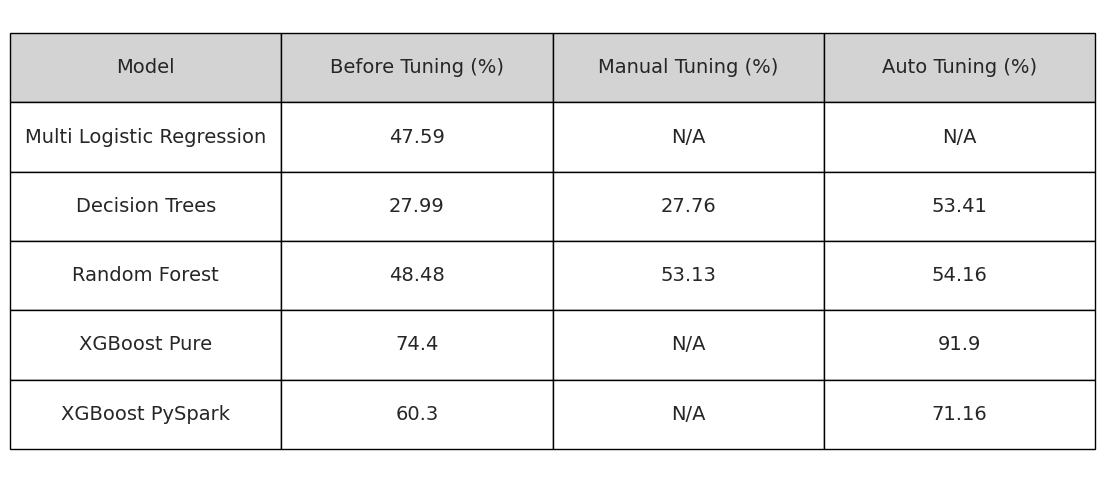

In [ ]:
import matplotlib.pyplot as plt

# Data
table_data = [
    ["Multi Logistic Regression", 47.59, "N/A", "N/A"],
    ["Decision Trees", 27.99, 27.76, 53.41],
    ["Random Forest", 48.48, 53.13, 54.16],
    ["XGBoost Pure", 74.40, "N/A", 91.9],
    ["XGBoost PySpark", 60.3, "N/A", 71.16]
]

# Create figure with bigger size
fig, ax = plt.subplots(figsize=(14, 6))  # Increased size for better readability
ax.axis('tight')
ax.axis('off')

# Create table
table = ax.table(cellText=table_data,
                 colLabels=["Model", "Before Tuning (%)", "Manual Tuning (%)", "Auto Tuning (%)"],
                 cellLoc='center', loc='center',
                 colColours=["lightgray"] * 4)  # Add color to column headers

# Adjust font size
table.auto_set_font_size(False)
table.set_fontsize(14)  # Bigger font size

# Increase row height and column width for more spacing
# Instead of cell padding (set_pad), adjust cell height and column width
for i, key in table._cells.items():
    key.set_height(0.15)  # Increase row height
    # key.set_pad(15)  # Remove or comment out this line (it causes the error)
    key.set_width(0.25)  # Adjust column width # Adjust as needed

# Show the table
plt.show()

## **Conclusion**


* Manual and Auto tuning significantly enhanced accuracy for the models, indicating that selecting hyperparameters based on domain expertise or experimentation can yield positive results.
* GridSearchCV or TrainValidationSplit tuning provide a substantial accuracy boost compared to manual tuning, suggesting that the initial manual adjustments were not very effective.
* Across all tuning methods, XGBoost consistently outperformed Decision Trees, Random Forest and Logistic Regression, underscoring the advantage of ensemble methods in achieving superior predictive performance.
* While achieving over 90% accuracy with the XGBoost model run in Pandas, it is encouraging that with larger dataset, choosing PySpark for training model will prove to be a better option.
* In the the future, further advancements in feature engineering, data preprocessing, or more sophisticated models could potentially drive even greater performance.

-----------------------------------------------------------------------------------------------------

## **VIII. Testing best Model on walmart_test dataset**

**Using XGBoost (PySpark) on test dataset**

In [ ]:
import joblib
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col


In [ ]:
feature_cols = ['VisitNumber', 'Upc', 'ScanCount', 'FinelineNumber', 'Department_Encoded', 'Weekday_Encoded',
                'TotalItems', 'ReturnItems', 'UniqueItems', 'DepartmentCount', 'DepartmentFrequency']

In [ ]:
spark = SparkSession.builder.appName("Walmart_XGBoost").getOrCreate()


In [ ]:
# Load the saved model
best_model = joblib.load("/content/drive/MyDrive/best_xgboost_model.pkl")


In [ ]:
walmart_test_pd = walmart_test.select(*feature_cols).toPandas()


In [ ]:
walmart_test_pd["Predicted_TripType"] = best_model.predict(walmart_test_pd)


In [ ]:
styled_df = walmart_test_pd.head(10).style.set_properties(**{'text-align': 'left'})
styled_df = styled_df.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
display(styled_df)

,VisitNumber,Upc,ScanCount,FinelineNumber,Department_Encoded,Weekday_Encoded,TotalItems,ReturnItems,UniqueItems,DepartmentCount,DepartmentFrequency,Predicted_TripType
0,1,1707710732,1,1526,0.068939,5,4,4,4,3,2,4
1,1,89470001026,1,1431,0.068939,5,4,4,4,3,2,30
2,1,88491211470,1,3555,0.111444,5,4,4,4,3,1,30
3,1,72503389714,1,3002,0.009235,5,4,4,4,3,1,22
4,3,7410811099,1,4504,0.066072,5,0,0,1,1,2,5
5,3,7410811099,-1,4504,0.066072,5,0,0,1,1,2,5
6,6,7603138508,1,654,0.005883,5,0,0,1,1,2,6
7,6,7603138508,-1,654,0.005883,5,0,0,1,1,2,6
8,13,5200032868,1,4606,0.107573,5,2,2,2,2,1,5
9,13,4470036001,1,7651,0.014380,5,2,2,2,2,1,4


-----------------------------------------------------

**NOTE**: IF Using XGBoost (without PySpark) to predict, run this code instead. Otherwise, skipping it.

In this situation, I choose the model 'best_model' run in PySpark with XGBClassifier as my main model for app building.

-----------------------------------------

**Using XGBoost (Pure) on test dataset**

In [ ]:
# Convert PySpark DataFrame to Pandas
pandas_test = walmart_test.toPandas()

# Extract the same feature columns used in training
X_test_new = pandas_test[feature_cols]  # Ensure feature_cols matches training

# Convert to XGBoost DMatrix for prediction
dtest_new = xgb.DMatrix(X_test_new)

# Make predictions using the trained model
preds_new = bst.predict(dtest_new)

# Decode predictions back to original TripType values
decoded_preds_new = label_encoder.inverse_transform(preds_new.astype(int))

# Add predicted 'TripType' to the pandas DataFrame
pandas_test['Predicted_TripType'] = decoded_preds_new

# Display the results
pandas_test_reset = pandas_test[['Predicted_TripType', 'VisitNumber', 'Upc', 'ScanCount', 'FinelineNumber', 'Department_Encoded',
                                 'Weekday_Encoded', 'TotalItems', 'ReturnItems', 'UniqueItems', 'DepartmentCount', 'DepartmentFrequency']]

# Display the DataFrame without the index column
pandas_test_reset = pandas_test_reset.reset_index(drop=True)

# Display the result
pandas_test_reset.head()


,Predicted_TripType,VisitNumber,Upc,ScanCount,FinelineNumber,Department_Encoded,Weekday_Encoded,TotalItems,ReturnItems,UniqueItems,DepartmentCount,DepartmentFrequency
0,41,1,1707710732,1,1526,0.068939,5,4,4,4,3,2
1,38,1,89470001026,1,1431,0.068939,5,4,4,4,3,2
2,41,1,88491211470,1,3555,0.111444,5,4,4,4,3,1
3,41,1,72503389714,1,3002,0.009235,5,4,4,4,3,1
4,8,3,7410811099,1,4504,0.066072,5,0,0,1,1,2


# **IX. Build an app to Predict Customer TripType**

In [ ]:
!pip install gradio
!pip install pandas ==1.5.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.0/322.0 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
tor

In [ ]:
# Set up Google Drive environment
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import gradio as gr
import joblib
import pandas as pd

# Load your trained model
model = joblib.load('/content/drive/MyDrive/best_xgboost_model.pkl')

# Define the prediction function
def predict_trip_type(VisitNumber, Upc, ScanCount, FinelineNumber, Department_Encoded,
                      Weekday_Encoded, TotalItems, ReturnItems, UniqueItems,
                      DepartmentCount, DepartmentFrequency):
    # Create a DataFrame from the input values
    input_data = pd.DataFrame([[VisitNumber, Upc, ScanCount, FinelineNumber, Department_Encoded,
                                Weekday_Encoded, TotalItems, ReturnItems, UniqueItems,
                                DepartmentCount, DepartmentFrequency]],
                              columns=['VisitNumber', 'Upc', 'ScanCount', 'FinelineNumber', 'Department_Encoded',
                                       'Weekday_Encoded', 'TotalItems', 'ReturnItems', 'UniqueItems',
                                       'DepartmentCount', 'DepartmentFrequency'])

    # Make the prediction
    prediction = model.predict(input_data)
    return f"The predicted Trip Type is: {prediction[0]}"

# Introduction screen with HTML styling
def show_intro():
    return """
    <div style="text-align: center;">
        <h1 style="color: blue; font-size: 32px;">Customer Trip Type Prediction</h1>
        <p style="font-size: 20px; font-weight: bold;">Team Member: Ly Le Minh - Tran Kim Khoi</p>
        <p>Click Start to begin.</p>
    </div>
    """

def start_app():
    return gr.update(visible=False), gr.update(visible=True)

with gr.Blocks() as demo:
    intro = gr.HTML(show_intro())  # Using HTML to format text
    start_button = gr.Button("Start", elem_id="start_button")

    with gr.Row(visible=False) as input_section:
        input_fields = [
            gr.Number(label="VisitNumber"),
            gr.Number(label="Upc"),
            gr.Number(label="ScanCount"),
            gr.Number(label="FinelineNumber"),
            gr.Number(label="Department_Encoded"),
            gr.Number(label="Weekday_Encoded"),
            gr.Number(label="TotalItems"),
            gr.Number(label="ReturnItems"),
            gr.Number(label="UniqueItems"),
            gr.Number(label="DepartmentCount"),
            gr.Number(label="DepartmentFrequency")
        ]
        output_text = gr.Textbox(label="Prediction")
        submit_button = gr.Button("Predict")
        submit_button.click(predict_trip_type, inputs=input_fields, outputs=output_text)

    start_button.click(start_app, inputs=[], outputs=[intro, input_section])

# Apply custom CSS for button styling
demo.css = """
    #start_button {
        font-size: 20px;
        font-weight: bold;
        color: white;
        background-color: orange;
        padding: 10px 20px;
        border: none;
        border-radius: 5px;
        cursor: pointer;
    }
"""

demo.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://44f35de43aadfcf33b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
